In [24]:
# Imports heapq module
from random import randint
from pea import PersistentEnglishAuction

import matplotlib.pyplot as plt
import numpy as np
import names

9
[(-96, 0.8163265306122449, 'Gordon'), (-73, 2.0408163265306123, 'Karen'), (-62, 3.2653061224489797, 'Dorothy'), (-93, 6.938775510204081, 'Gregory'), (-82, 6.122448979591837, 'Joann'), (-90, 10.612244897959183, 'John'), (-98, 13.877551020408163, 'Clarence'), (-95, 12.244897959183675, 'Amy'), (-95, 17.551020408163264, 'Louise')]


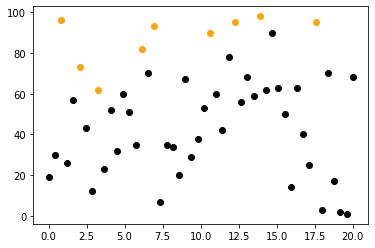

In [167]:
# Simulate
auction = PersistentEnglishAuction(time_between_clearing=2, max_clears=10, auction_start_time=2)

# generate times to bid
x = np.linspace(0, 20, 50)

# Generate random value to bid
y = [randint(1, 100) for num in x]

for i in range(len(x)):
    auction.add_bid(address=names.get_first_name(), bid=y[i], bid_time=x[i])


bidders = auction.get_bidders()
winners = auction.get_winners()

plt.plot([bidder[1] for bidder in bidders], [(-bidder[0]) for bidder in bidders], 'o', color='black')
plt.plot([winner[1] for winner in winners], [(-winner[0]) for winner in winners], 'o', color="orange")